# Predicting the stock prices

# <font color="darkblue">Table of Contents</font>
1. [The project](#toc1)
2. [The dataset](#toc2)
3. [Feature engineering](#toc3)  
3.1. [Date Time Features](#toc31)  
3.2 [Lag Features](#toc32)
4. [Splitting up the data](#toc4)
5. [Making predictions](#toc5)  
5.1 [Ridge Regression](#toc51)  
5.2 [Random Forest Regression](#toc52)  
5.3 [K-Nearest Neighbor Regression](#toc53)  
6. [Conclusion](#toc6)

<a id=toc1></a>

# 1. The project 

In this project, we will explore different regression algorithms from the scikit-learn library on stock prices 
prediction :
* Ridge Regression
* Random Forest
* SVM

In [262]:
import os
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split
import warnings
warnings.filterwarnings('ignore')

#To visualize graphs on jupyter notebook
%matplotlib inline
#PATH of the project folder
PROJECT_ROOT_DIR=os.getcwd()
#Create Images folder
IMAGES_PATH=os.path.join(PROJECT_ROOT_DIR,"Images")
if not os.path.exists(IMAGES_PATH):
    os.makedirs(IMAGES_PATH)
    
#Function to save figures in the images folder
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(IMAGES_PATH, fig_id + ".png")
    print("Figure {} saved".format(fig_id))
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

<a id=toc2></a>
# 2. The Dataset

We will study the stock prices of Tesla

The columns of the dataset are:

- **Date** -- The date of the record.
- **Open** -- The opening price of the day.
- **High** -- The highest trade price during the day.
- **Low** -- The lowest trade price during the day.
- **Close** -- The closing price for the day.
- **Volume** -- The number of shares traded.
- **Adj Close** -- The daily closing price, adjusted retroactively to include any corporate actions. <strong>We want to predict this column</strong>

In [263]:
#Read the csv file . into a Pandas DataFrame
market=pd.read_csv("TSLA.csv")
market["Date"]=pd.to_datetime(market["Date"])

In [264]:
print(market.dtypes)

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object


In [265]:
len(market)

2310

Figure Adjusted_Closing_Price_over_time saved


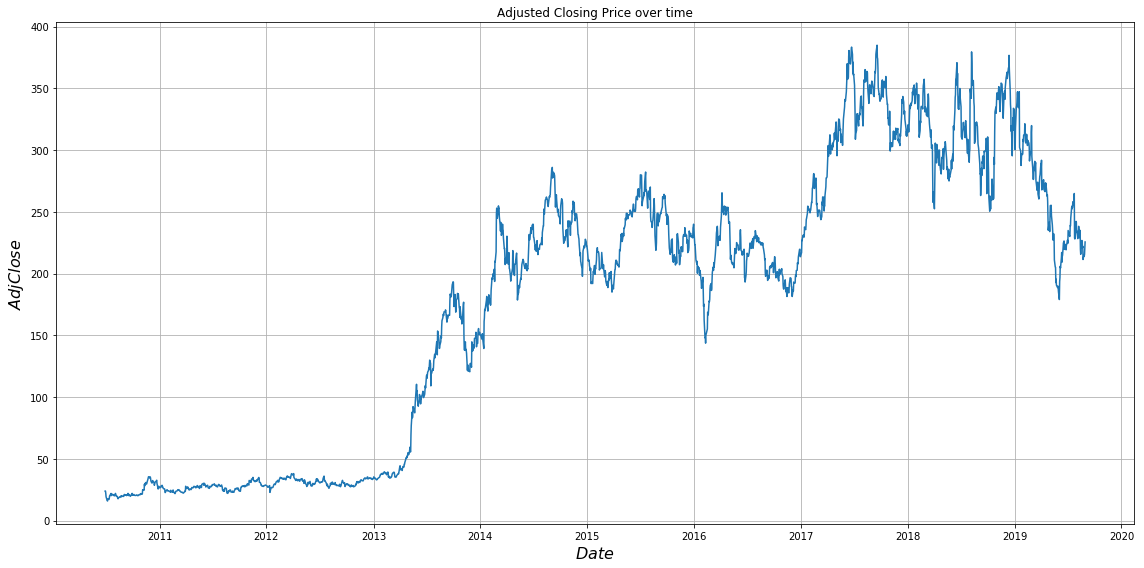

In [266]:
plt.figure(figsize=(16,8))
plt.plot(market['Date'],market['Adj Close'])
plt.grid()
plt.xlabel("$Date$",fontsize=16)
plt.ylabel("$Adj Close$",fontsize=16)
plt.title("Adjusted Closing Price over time")
save_fig("Adjusted_Closing_Price_over_time")
plt.show()

<a id=toc3></a>
# 3. Feature Engineering

<a id=toc31></a>
## &emsp; 3.1 Date Time Features

First we can extract the year, month and day of the "Date" and create cyclical features

In [267]:
def handle_date(df):
    '''
    Signature: 
    handle_date(df)

    Docstring:
    Extract features from Date column 
    Return the new DataFrame

    Parameters
    ----------
    df : Pandas DataFrame

    Returns
    -------
    df : Pandas DataFrame
    '''

    #Create new columns based on the date column
    df["year"]=df['Date'].dt.year
    df["month"]=df['Date'].dt.month
    df["day_week"]=df["Date"].dt.weekday
    df["day_month"]=df["Date"].dt.day
  
    #Create a cyclical Features for the distance proximity for the month feature
    df['month_sin'] = np.sin((df["month"]-1)*(2.*np.pi/12))
    df['month_cos'] = np.cos((df["month"]-1)*(2.*np.pi/12))

    #Create the cyclical Features for distance proximity for the day feature
    df['day_month_sin'] = np.sin(df["day_month"]*(2.*np.pi/31))
    df['day_month_cos'] = np.cos(df["day_month"]*(2.*np.pi/31))
    
    #Create the cyclical Features for distance proximity for the day of the week feature
    df['day_week_sin'] = np.sin(df["day_week"]*(2.*np.pi/5))
    df['day_week_cos'] = np.cos(df["day_week"]*(2.*np.pi/5))
    
    #Remove unnecessary columns
    del df['month']
    del df['day_week']
    del df['day_month']
  
    return df

In [268]:
#Update the DataFrame
market=handle_date(market)

In [269]:
market.head()

,Date,Open,High,Low,Close,Adj Close,Volume,year,month_sin,month_cos,day_month_sin,day_month_cos,day_week_sin,day_week_cos
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300,2010,5.000000e-01,-0.866025,-0.394356,0.918958,0.951057,0.309017
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100,2010,5.000000e-01,-0.866025,-0.201299,0.979530,0.587785,-0.809017
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800,2010,1.224647e-16,-1.000000,0.201299,0.979530,-0.587785,-0.809017
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800,2010,1.224647e-16,-1.000000,0.394356,0.918958,-0.951057,0.309017
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900,2010,1.224647e-16,-1.000000,0.937752,0.347305,0.951057,0.309017


In [270]:
market.sort_values(by='Date',inplace=True)
market.head()

,Date,Open,High,Low,Close,Adj Close,Volume,year,month_sin,month_cos,day_month_sin,day_month_cos,day_week_sin,day_week_cos
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300,2010,5.000000e-01,-0.866025,-0.394356,0.918958,0.951057,0.309017
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100,2010,5.000000e-01,-0.866025,-0.201299,0.979530,0.587785,-0.809017
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800,2010,1.224647e-16,-1.000000,0.201299,0.979530,-0.587785,-0.809017
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800,2010,1.224647e-16,-1.000000,0.394356,0.918958,-0.951057,0.309017
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900,2010,1.224647e-16,-1.000000,0.937752,0.347305,0.951057,0.309017


<a id=toc32></a>
## &emsp; 3.2 Lag Features

To make this more robust, we will add the past month prices $N - 31$ (arbitrary). Each past price will be a new feature therefore a new colum. We will add also different features with the rolling function. we will use a window of 5 (a week) and 31 for the rolling function.

In [271]:
def shift_function(df, window, rolling1,rolling2):
    '''
    Signature: 
    shift_function(df)

    Docstring:
    Create columns for past value feature 
    Return the new DataFrame

    Parameters
    ----------
    df : Pandas DataFrame
    window : number of past values
    rolling1 : first rolling window
    rolling2 : second rolling window

    Returns
    -------
    df : Pandas DataFrame
    '''
    #Raw values
    for i in range(1,window+1):
        df['t-'+str(i)]=df['Adj Close'].shift(i)
        
    #Rolling1 mean
    df['rolling _mean_'+str(rolling1)]=df['Adj Close'].rolling(rolling1).mean()
    #Rolling1 std
    df['rolling _std_'+str(rolling1)]=df['Adj Close'].rolling(rolling1).std()
    #Rolling1 min
    df['rolling _min_'+str(rolling1)]=df['Adj Close'].rolling(rolling1).min()
    #Rolling1 max
    df['rolling _max_'+str(rolling1)]=df['Adj Close'].rolling(rolling1).max()
    
    #Rolling2 mean
    df['rolling _mean_'+str(rolling2)]=df['Adj Close'].rolling(rolling2).mean()
    #Rolling2 std
    df['rolling _std_'+str(rolling2)]=df['Adj Close'].rolling(rolling2).std()
    #Rolling2 min
    df['rolling _min_'+str(rolling2)]=df['Adj Close'].rolling(rolling2).min()
    #Rolling2 max
    df['rolling _max_'+str(rolling2)]=df['Adj Close'].rolling(rolling2).max()
    df.dropna(inplace=True)
    return df

In [272]:
market=shift_function(market,31,5,31)

In [273]:
market.head()

,Date,Open,High,Low,Close,Adj Close,Volume,year,month_sin,month_cos,...,t-30,t-31,rolling _mean_5,rolling _std_5,rolling _min_5,rolling _max_5,rolling _mean_31,rolling _std_31,rolling _min_31,rolling _max_31
31,2010-08-12,17.799999,17.900000,17.389999,17.600000,17.600000,691000,2010,-0.5,-0.866025,...,23.830000,23.889999,18.744,0.942247,17.6,19.600000,19.769355,1.846371,15.8,23.830000
32,2010-08-13,18.180000,18.450001,17.660000,18.320000,18.320000,634000,2010,-0.5,-0.866025,...,21.959999,23.830000,18.490,0.820488,17.6,19.600000,19.591613,1.702009,15.8,21.959999
33,2010-08-16,18.450001,18.799999,18.260000,18.780001,18.780001,485800,2010,-0.5,-0.866025,...,19.200001,21.959999,18.326,0.593785,17.6,19.030001,19.489032,1.649528,15.8,21.950001
34,2010-08-17,18.959999,19.400000,18.780001,19.150000,19.150000,447900,2010,-0.5,-0.866025,...,16.110001,19.200001,18.350,0.630635,17.6,19.150000,19.487419,1.649844,15.8,21.950001
35,2010-08-18,19.590000,19.590000,18.600000,18.770000,18.770000,601300,2010,-0.5,-0.866025,...,15.800000,16.110001,18.524,0.594416,17.6,19.150000,19.573226,1.533396,15.8,21.950001


# <a id=toc4></a>
# 4. Splitting up the data

In [274]:
features=market.drop(['Date','High','Low','Open','Close','Volume','Adj Close'],axis=1).columns

In [275]:
features

Index(['year', 'month_sin', 'month_cos', 'day_month_sin', 'day_month_cos',
       'day_week_sin', 'day_week_cos', 't-1', 't-2', 't-3', 't-4', 't-5',
       't-6', 't-7', 't-8', 't-9', 't-10', 't-11', 't-12', 't-13', 't-14',
       't-15', 't-16', 't-17', 't-18', 't-19', 't-20', 't-21', 't-22', 't-23',
       't-24', 't-25', 't-26', 't-27', 't-28', 't-29', 't-30', 't-31',
       'rolling _mean_5', 'rolling _std_5', 'rolling _min_5', 'rolling _max_5',
       'rolling _mean_31', 'rolling _std_31', 'rolling _min_31',
       'rolling _max_31'],
      dtype='object')

In [276]:
# Train and test split
split_fraction = 0.8
ind_split = int(split_fraction * len(market))
train = market[:ind_split]
test = market[ind_split:]

In [277]:
X_train=train[features]
y_train=train['Adj Close']

X_test=test[features]
y_test=test['Adj Close']

In [278]:
X_train.head()

,year,month_sin,month_cos,day_month_sin,day_month_cos,day_week_sin,day_week_cos,t-1,t-2,t-3,...,t-30,t-31,rolling _mean_5,rolling _std_5,rolling _min_5,rolling _max_5,rolling _mean_31,rolling _std_31,rolling _min_31,rolling _max_31
31,2010,-0.5,-0.866025,0.651372,-0.758758,-0.587785,-0.809017,17.900000,19.030001,19.600000,...,23.830000,23.889999,18.744,0.942247,17.6,19.600000,19.769355,1.846371,15.8,23.830000
32,2010,-0.5,-0.866025,0.485302,-0.874347,-0.951057,0.309017,17.600000,17.900000,19.030001,...,21.959999,23.830000,18.490,0.820488,17.6,19.600000,19.591613,1.702009,15.8,21.959999
33,2010,-0.5,-0.866025,-0.101168,-0.994869,0.000000,1.000000,18.320000,17.600000,17.900000,...,19.200001,21.959999,18.326,0.593785,17.6,19.030001,19.489032,1.649528,15.8,21.950001
34,2010,-0.5,-0.866025,-0.299363,-0.954139,0.951057,0.309017,18.780001,18.320000,17.600000,...,16.110001,19.200001,18.350,0.630635,17.6,19.150000,19.487419,1.649844,15.8,21.950001
35,2010,-0.5,-0.866025,-0.485302,-0.874347,0.587785,-0.809017,19.150000,18.780001,18.320000,...,15.800000,16.110001,18.524,0.594416,17.6,19.150000,19.573226,1.533396,15.8,21.950001


In [279]:
y_train.head()

31    17.600000
32    18.320000
33    18.780001
34    19.150000
35    18.770000
Name: Adj Close, dtype: float64

# <a id=toc5></a>
# 5. Making Prediction

In [280]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import  StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

We will normalize all the features to have the same scale for each feature

In [281]:
std=StandardScaler()
X_train_scaled=std.fit_transform(X_train)
X_test_scaled=std.transform(X_test)

In [282]:
def ml_reg(Algo):
    '''
    Signature: 
    ml_reg(df)

    Docstring:
    select, train and make predictions fo a specific algorithm

    Parameters
    ----------
    Algo : Algorithm class


    Returns
    -------
    mae_train : mean absolute error between train set and predictions
    rmse_train : root mean squared error between train set and predictions
    predicition_train : the result of the predict method for the train set
    
    mae_test : mean absolute error between test set and predictions
    rmse_test : root mean squared error between test set and predictions
    predicition_test : the result of the predict method for the test set
    
    ml : the algorithm used
    '''
    ml=Algo
    ml.fit(X_train_scaled,y_train)
    
    # Prediction of the train and mae et rmse of the predictions
    predictions_train=ml.predict(X_train_scaled)
    mae_train=mean_absolute_error(y_train,predictions_train)
    rmse_train=mean_squared_error(y_train,predictions_train)**(1/2)
    
    # Prediction of the test and mae et rmse of the predictions
    predictions_test=ml.predict(X_test_scaled)
    mae_test=mean_absolute_error(y_test,predictions_test)
    rmse_test=mean_squared_error(y_test,predictions_test)**(1/2)
    return mae_train,rmse_train,predictions_train,mae_test,rmse_test,predictions_test,ml

In [283]:
def plot_predictions(data,actual_data,prediction,name_algo,train_or_test):
    '''
    Signature: 
    plot_predictions(df)

    Docstring:
    Visualization of the prediction VS the acutal data

    Parameters
    ----------
    data : DataFrame for the abscisse
    actual_data : value of the actual dependant variable y
    prediction : the predict values by a ML algorithm
    name_algo : Algorithm linked to the prediction
    train_or_test : text to specified if we're looking for the train set or the test set

    Returns
    -------
    '''
        
    plt.figure(figsize=(16,8))
    plt.plot(data["Date"],actual_data,'b',label=train_or_test,linewidth=2)
    plt.plot(data["Date"],prediction,'r',label='prediction',linewidth=2)
    plt.grid()
    plt.xlabel("$Date$",fontsize=16)
    plt.ylabel("$Adj Close$",fontsize=16)
    plt.title("Adjusted Closing Price over time_"+name_algo+"_"+str(train_or_test), fontsize=16)
    plt.legend()
    save_fig("Adjusted_Closing_Price_over_time_"+name_algo+"_"+str(train_or_test))
    plt.show()
    
    return 0

<a id=toc51></a>
## &emsp; 5.1 Ridge Regression

In [284]:
mae_ridge_train,rmse_ridge_train,predictions_ridge_train,mae_ridge_test,rmse_ridge_test,predictions_ridge_test,ml_ridge=ml_reg(Ridge())
print("Error for the Ridge model :")
print("mae_train: {} ,rmse_train : {}".format(mae_ridge_train,rmse_ridge_train))
print("mae_test: {} ,rmse_test : {}".format(mae_ridge_test,rmse_ridge_test))

Error for the Ridge model :
mae_train: 2.0663202624510415 ,rmse_train : 3.095061085927621
mae_test: 4.986637844794817 ,rmse_test : 6.734238188743024


Figure Adjusted_Closing_Price_over_time_Ridge_train saved


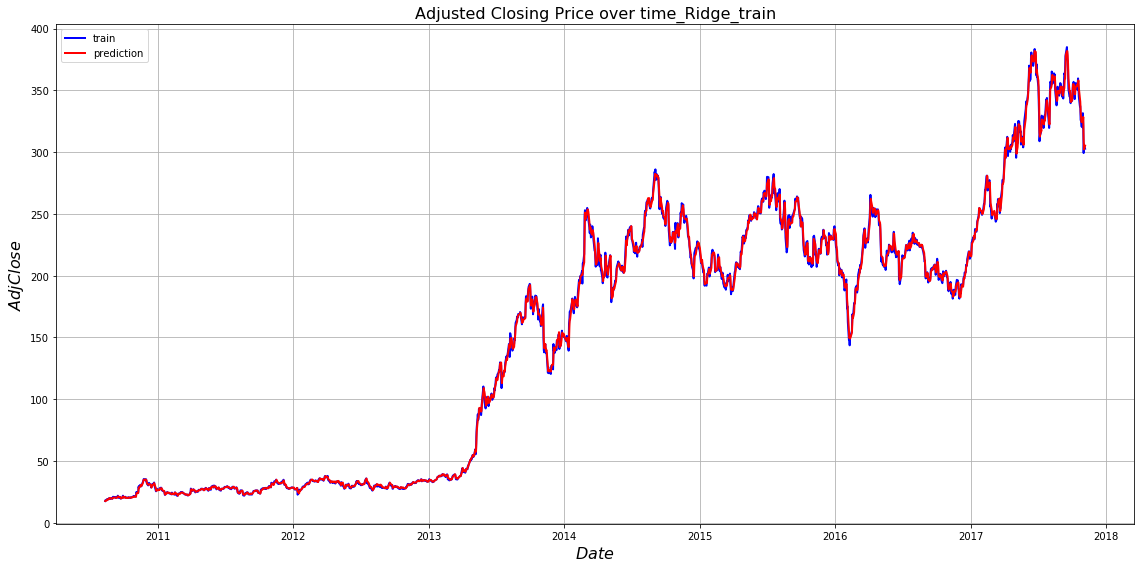

0

In [285]:
plot_predictions(train,y_train,predictions_ridge_train,'Ridge','train')

Figure Adjusted_Closing_Price_over_time_Ridge_test saved


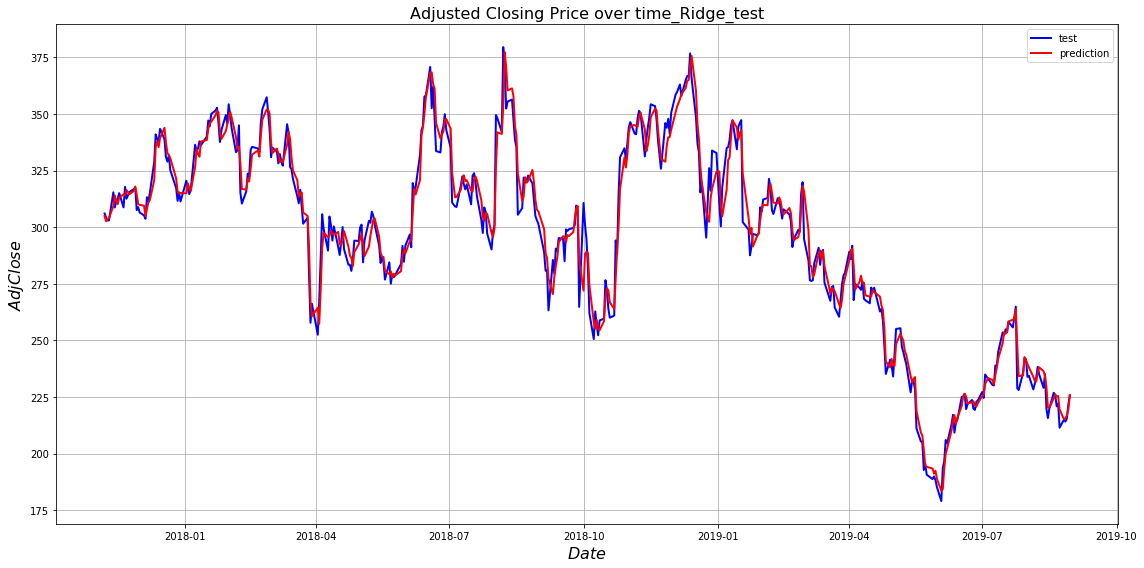

0

In [286]:
plot_predictions(test,y_test,predictions_ridge_test,'Ridge','test')

<a id=toc52></a>
## &emsp; 5.2 Random Forest Regression

In [287]:
mae_rf_train,rmse_rf_train,predictions_rf_train,mae_rf_test,rmse_rf_test,predictions_rf_test,ml_rf=ml_reg(RandomForestRegressor())
print("Error for the Random Forest model :")
print("mae_train: {} ,rmse_train : {}".format(mae_rf_train,rmse_rf_train))
print("mae_test: {} ,rmse_test : {}".format(mae_rf_test,rmse_rf_test))

Error for the Random Forest model :
mae_train: 1.1491497240811848 ,rmse_train : 1.9702638306604667
mae_test: 8.050716837938596 ,rmse_test : 10.733912275613005


Figure Adjusted_Closing_Price_over_time_Random_Forest_train saved


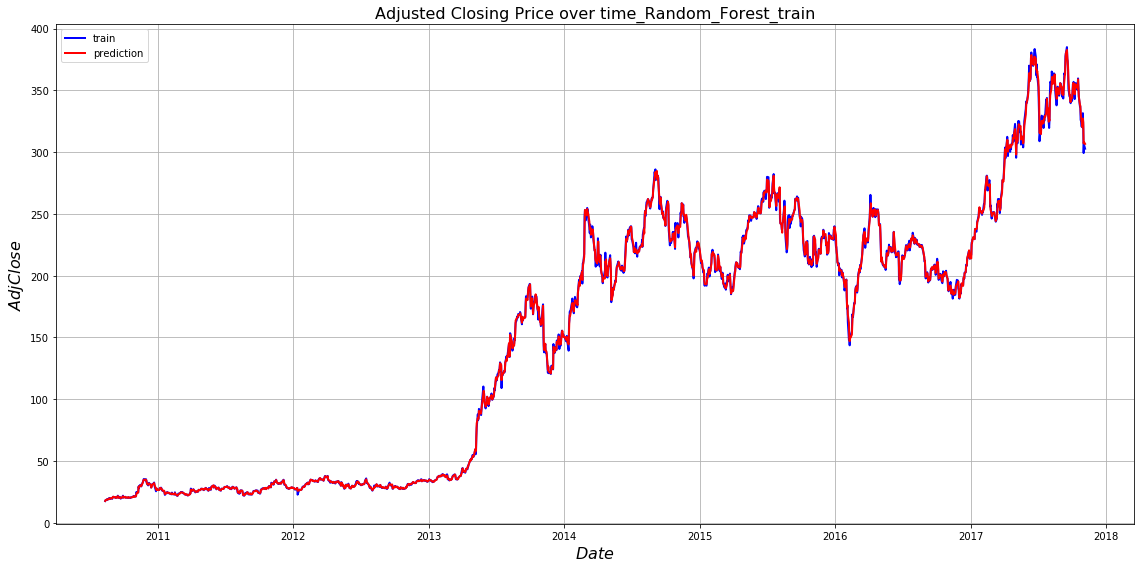

0

In [288]:
plot_predictions(train,y_train,predictions_rf_train,'Random_Forest','train')

Figure Adjusted_Closing_Price_over_time_Random_Forest_test saved


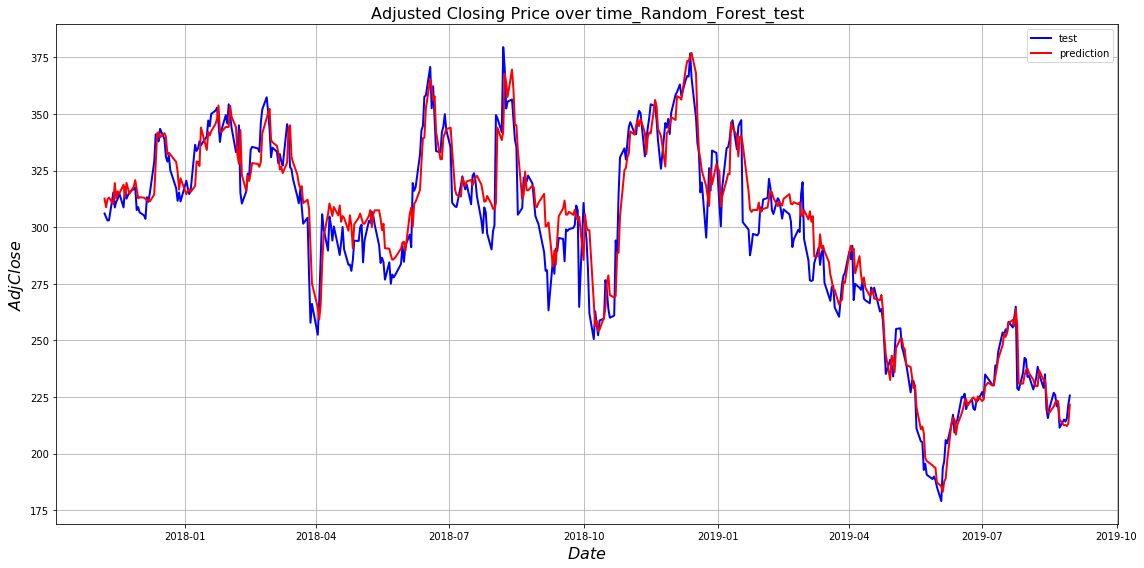

0

In [289]:
plot_predictions(test,y_test,predictions_rf_test,'Random_Forest','test')

<a id=toc53></a>
## &emsp; 5.3 K-Nearest Neighbor Regression

In [290]:
mae_knn_train,rmse_knn_train,predictions_knn_train,mae_knn_test,rmse_knn_test,predictions_knn_test,ml_knn=ml_reg(KNeighborsRegressor())
print("Error for the Knn model :")
print("mae_train: {} ,rmse_train : {}".format(mae_knn_train,rmse_knn_train))
print("mae_test: {} ,rmse_test : {}".format(mae_knn_test,rmse_knn_test))


Error for the Knn model :
mae_train: 4.94494021799232 ,rmse_train : 6.747731029842636
mae_test: 20.918171092982455 ,rmse_test : 26.094051066340402


Figure Adjusted_Closing_Price_over_time_knn_train saved


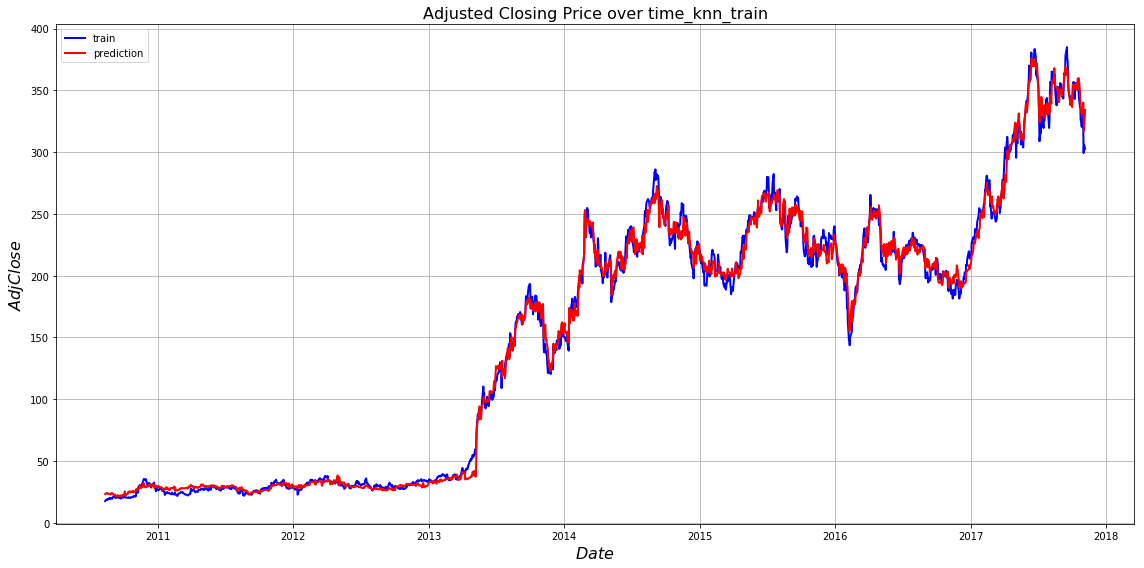

0

In [291]:
plot_predictions(train,y_train,predictions_knn_train,'knn','train')

Figure Adjusted_Closing_Price_over_time_knn_test saved


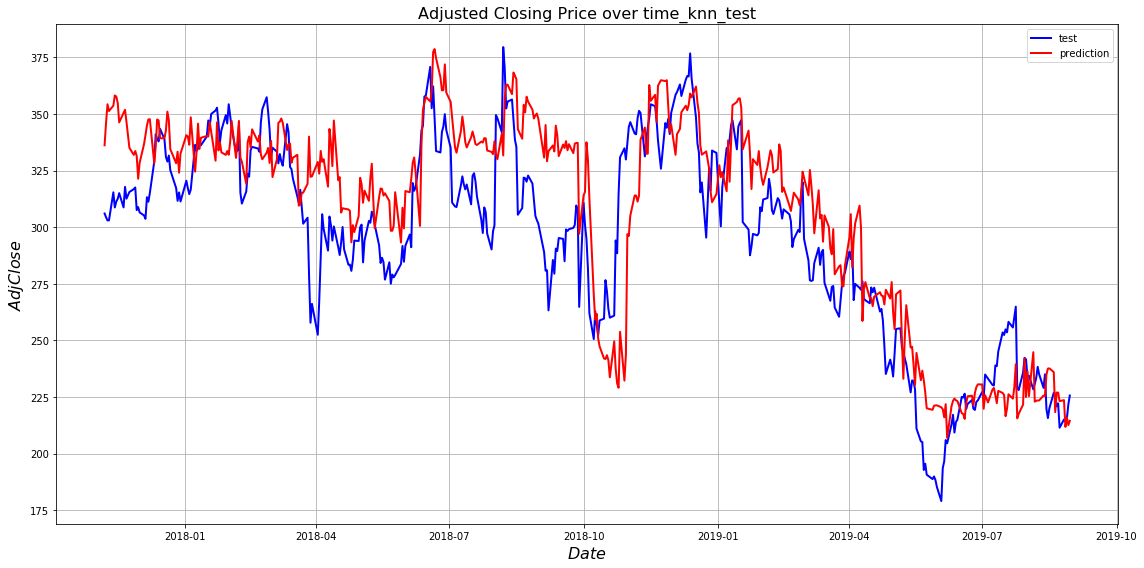

0

In [292]:
plot_predictions(test,y_test,predictions_knn_test,'knn','test')

<a id=toc6></a>
# 6. Conclusion

### Finally, we will plot everything together !

### For the train set

Figure Adjusted_Closing_Price_over_time_All_models_train saved


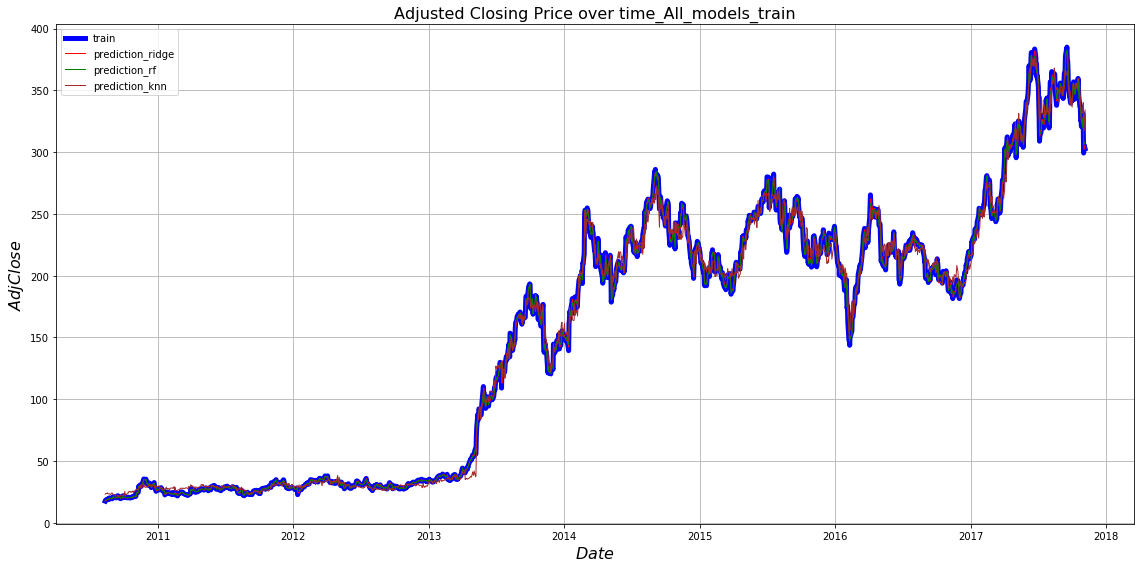

In [293]:
plt.figure(figsize=(16,8))
plt.plot(train["Date"],y_train,'b',label='train',linewidth=5)
plt.plot(train["Date"],predictions_ridge_train,'r',label='prediction_ridge',linewidth=1)
plt.plot(train["Date"],predictions_rf_train,'g',label='prediction_rf',linewidth=1)
plt.plot(train["Date"],predictions_knn_train,'brown',label='prediction_knn',linewidth=1)

plt.grid()
plt.xlabel("$Date$",fontsize=16)
plt.ylabel("$Adj Close$",fontsize=16)
plt.title("Adjusted Closing Price over time_All_models_train", fontsize=16)
plt.legend()
save_fig("Adjusted_Closing_Price_over_time_All_models_train")
plt.show()

It's seems that the different models aren't underfitting but they're maybe overfitting. We can see that with the test set

### For the test set

Figure Adjusted_Closing_Price_over_time_All_models_test saved


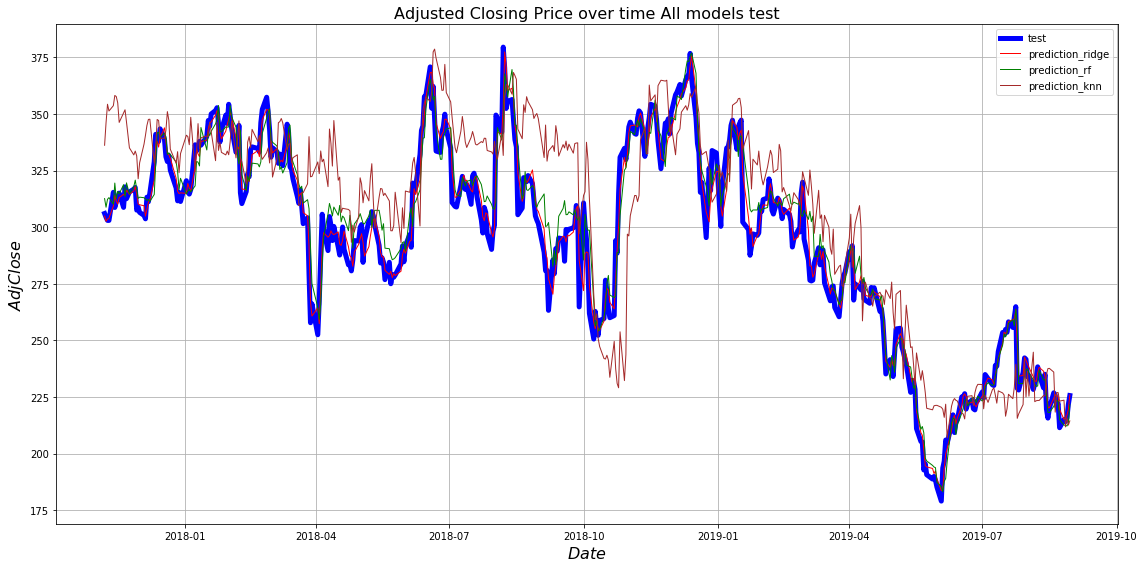

In [294]:
plt.figure(figsize=(16,8))
plt.plot(test["Date"],y_test,'b',label='test',linewidth=5)
plt.plot(test["Date"],predictions_ridge_test,'r',label='prediction_ridge',linewidth=1)
plt.plot(test["Date"],predictions_rf_test,'g',label='prediction_rf',linewidth=1)
plt.plot(test["Date"],predictions_knn_test,'brown',label='prediction_knn',linewidth=1)

plt.grid()
plt.xlabel("$Date$",fontsize=16)
plt.ylabel("$Adj Close$",fontsize=16)
plt.title("Adjusted Closing Price over time All models test", fontsize=16)
plt.legend()
save_fig("Adjusted_Closing_Price_over_time_All_models_test")
plt.show()

The knn is the worst model of the three, this algorithm doesn't seem to be very suitable for time series model. The Random forest find the overall trend for most of the test. The Ridge has the lowest error but if we look closely we can see that there is lags. In a time series dataset, we have to be carreful with this (that's why it follows the noise). For stock market, it is the best to see if the price will go up or down. Maybe a classification problem would be more appropriate.
To improve the models, we could adjust the parameters of the lag features for example. Is it best to take less past prices into account ? What about the rolling function ? 
We could also try deep learning algorithm like a RNN.


### A lot of room for improvement !